In [150]:
import os
import cv2
import re
import json
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 20)

def annotate_image(img, detections):
    lime = (0,255,0)
    black = (0,0,0)
    font = cv2.FONT_HERSHEY_PLAIN
    # Bib regions (draw first)
    for region in detections:
        x1 = region["x1"]
        y1 = region["y1"]
        x2 = region["x2"]
        y2 = region["y2"]
        cv2.rectangle(img, (x1, y1), (x2, y2), lime, 2)
    # labels for accuracy (overlay)
    for region in detections:
        x1 = region["x1"]
        y1 = region["y1"]
        x2 = region["x2"]
        y2 = region["y2"]
        acc = region["accuracy"]
        label = "%s%%" % int(acc * 100)
        fnt_sz, baseline = cv2.getTextSize(label, font, 1, 1)
        acc_rect_pt1 = (x1, y1 + baseline - 5)
        acc_rect_pt2 = (x1 + fnt_sz[0] + 5, y1 - fnt_sz[1] - 5)
        cv2.rectangle(img, acc_rect_pt1, acc_rect_pt2, lime, -1)
        cv2.putText(img, label, (x1,y1), font, 1, black)
    return img

def crop_region(image, region):
    """Crops a singular region in an image
    Args:
        image (image): A numpy image
        region (dict): A dictionary containing x1, y1, x2, y2
    Returns:
        image: The cropped image
    """
    x1 = region["x1"] 
    y1 = region["y1"]
    w = region["x2"] - x1
    h = region["y2"] - y1
    return image[y1: y1 + h, x1: x1 + w]

def region_area(region):
    """Returns the area of the specified region.
    Args:
        region (dict): A dictionary containing {x1, y1, x2, y2} arguments.
    Returns:
        float: The area of the region.
    """
    w = region["x2"] - region["x1"]
    h = region["y2"] - region["y1"]
    return w * h

def do_regions_intersect(r1, r2):
    """Calculates whether or not the two regions intersect eachother.
    Args:
        r1, r2 (dict): A dictionary containing {x1, y1, x2, y2} arguments.
    Returns:
        boolean: True if the regions intersect, false otherwise.
    """
    dx = min(r1["x2"], r2["x2"]) - max(r1["x1"], r2["x1"])
    dy = min(r1["y2"], r2["y2"]) - max(r1["y1"], r2["y1"])
    return (dx > 0) and (dy > 0)

def read_json(json_filename):
    """Reads the JSON file as a dictionary.
    Args:
        json_filename (string): The JSON file to read.
    Returns:
        dict: The JSON data, parsed as a dictionary.
    """
    with open(json_filename, 'r') as json_fp:
        json_data = json.load(json_fp)
    return json_data

def extract_bib_regions_from_image(image_filename, bib_json_dir, person_json_dir = None):
    """Extracts valid bibs from the image.
    
    By `valid', we mean those regions which do not overlap. If a person_json_dir is provided
    we will calculate the regions where there are possible overlaps in two people's 
    detections. We also adjust these coordinates from the cropped images to the original 
    images.
    
    Args:
        image_filename (string): Path to ORIGINAL image filename.
        bib_json_dir (string): Path of bib JSON files.
        person_json_dir (string): Path of person crop JSON files. If not provided,
                                  then assume non-crop images provided.
    Returns:
        list of dict: A list of the regions with their respective accuracies.
    """
    # Strip the image id from the original filename
    image_id = os.path.splitext(os.path.basename(image_filename))[0]
    
    # Read in the image
    image = cv2.imread(image_filename)
    
    # If a person JSON directory is provided, then we need to combine all
    # detected bibs for each respective person
    if person_json_dir is not None:
        person_regions = read_json("%s/%s.json" % (person_json_dir, image_id))["person"]["regions"]
        
        # Now I have all of my person_regions, I cna find the respective bib regions
        # for every single person
        for i, person_region in enumerate(person_regions):
            # These are the person's coordinates in the ORIGINAL image
            px1, py1 = (person_region["x1"], person_region["y1"])
            bib_filename = "%s/%s_crop_person_%i.json" % (bib_json_dir, image_id, i)
            person_region["bib_regions"] = read_json(bib_filename)["bib"]["regions"]
            
            # Now we must mutate each of these bib regions to be reflective
            # of the ORIGINAL image's dimension sizes
            for bib_region in person_region["bib_regions"]:
                bib_region["x1"] += px1
                bib_region["y1"] += py1
                bib_region["x2"] += px1
                bib_region["y2"] += py1
        
        # Now strip out all bib regions in the entire photo for every runner
        bib_regions = np.hstack([person_region["bib_regions"] for person_region in person_regions])

        # Go through every bib region we have, and see if any bibs overlap.
        # If they do, then use the larger area rectangle.
        bib_regions_to_remove = []
        for bib_region in bib_regions:
            for other_bib_region in bib_regions:
                if bib_region == other_bib_region:
                    continue
                if do_regions_intersect(bib_region, other_bib_region):
                    bib_region_area = region_area(bib_region)
                    other_bib_region_area = region_area(other_bib_region)
                    if bib_region_area > other_bib_region_area:
                        bib_regions_to_remove.append(other_bib_region)
        bib_regions = [bib_region for bib_region in bib_regions 
                       if bib_region not in bib_regions_to_remove]
    else:
        bib_regions = read_json("%s/%s.json" % (bib_json_dir, image_id))["bib"]["regions"]
    
    return bib_regions

def crop_bib_regions_from_image(image_filename, bib_regions):
    """Crops the specified bib regions from the given image.
    Args:
        image_filename (string): Path to ORIGINAL image filename.
        bib_regions (dict): The bib regions to crop.
    Returns:
        numpy3d: Numpy 3D array of cropped images
    """
    image = cv2.imread(image_filename)
    return [crop_region(image, bib_region) for bib_region in bib_regions]

def bib_regions_to_json(bib_regions):
    return json.dumps({
        "bib": {
            "regions": bib_regions
        }
    })

def save_bib_regions_to_json(filename, bib_regions)

Populating the interactive namespace from numpy and matplotlib


# Test 1

This test **uses** person cropping.

{"bib": {"regions": [{"y1": 2961, "x2": 1713, "x1": 1422, "y2": 3194, "accuracy": 0.9893071055412292}, {"y1": 2086, "x2": 2471, "x1": 2121, "y2": 2378, "accuracy": 0.9865506887435913}, {"y1": 1736, "x2": 3404, "x1": 3112, "y2": 2028, "accuracy": 0.907068133354187}, {"y1": 1503, "x2": 3404, "x1": 3287, "y2": 1620, "accuracy": 0.8771738409996033}, {"y1": 1796, "x2": 1574, "x1": 1336, "y2": 1987, "accuracy": 0.9996660947799683}, {"y1": 1416, "x2": 1955, "x1": 1860, "y2": 1511, "accuracy": 0.9199181199073792}, {"y1": 1952, "x2": 4438, "x1": 4085, "y2": 2187, "accuracy": 0.9990133047103882}, {"y1": 1796, "x2": 3968, "x1": 3694, "y2": 1992, "accuracy": 0.9794244766235352}, {"y1": 2070, "x2": 4634, "x1": 4438, "y2": 2305, "accuracy": 0.9162489175796509}, {"y1": 1404, "x2": 4555, "x1": 4399, "y2": 1482, "accuracy": 0.8268589973449707}]}}


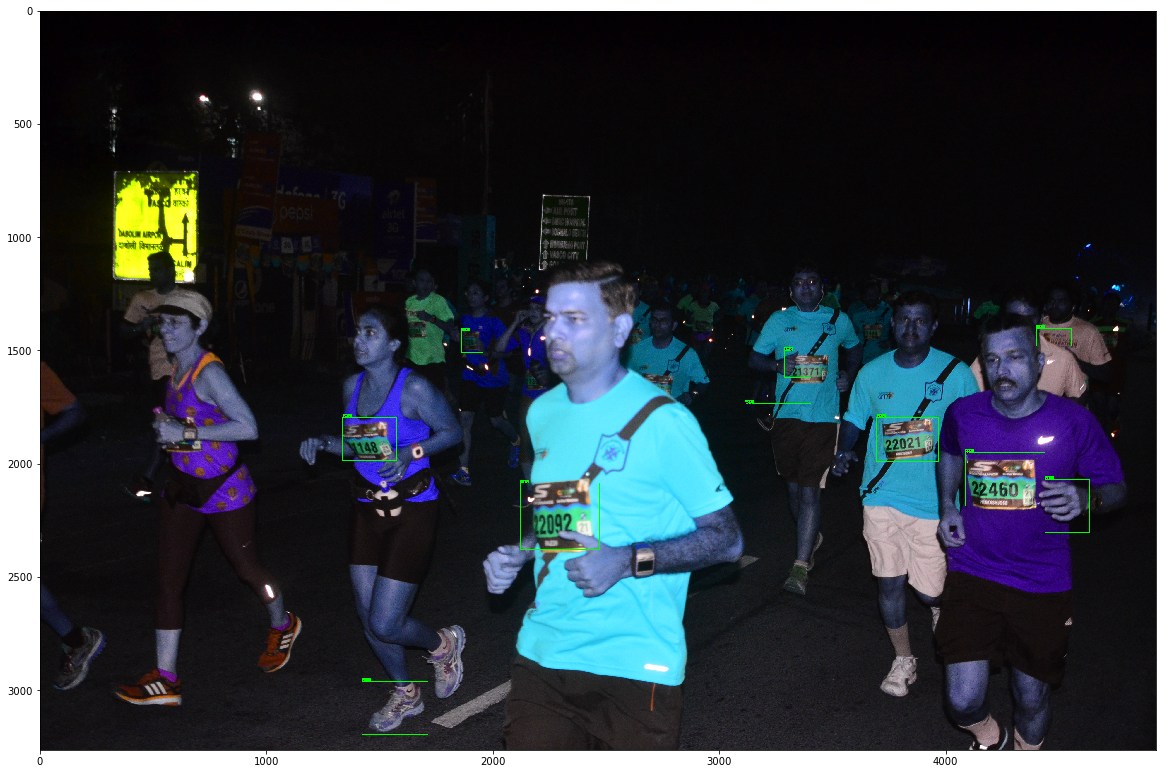

In [151]:
filename = "/Users/Alex/Desktop/yolo_crop/run4/2dc85b4090468f66b12eaaf8c1a76c8a.jpg"

bib_regions = extract_bib_regions_from_image(filename, 
                                             "/Users/Alex/Desktop/yolo_crop/run4/bib",
                                             "/Users/Alex/Desktop/yolo_crop/run4/person")

plt.imshow(annotate_image(cv2.imread(filename), bib_regions))

# Test 2

This person **does not** use person cropping. As you can see, `22021` is **not detected**.

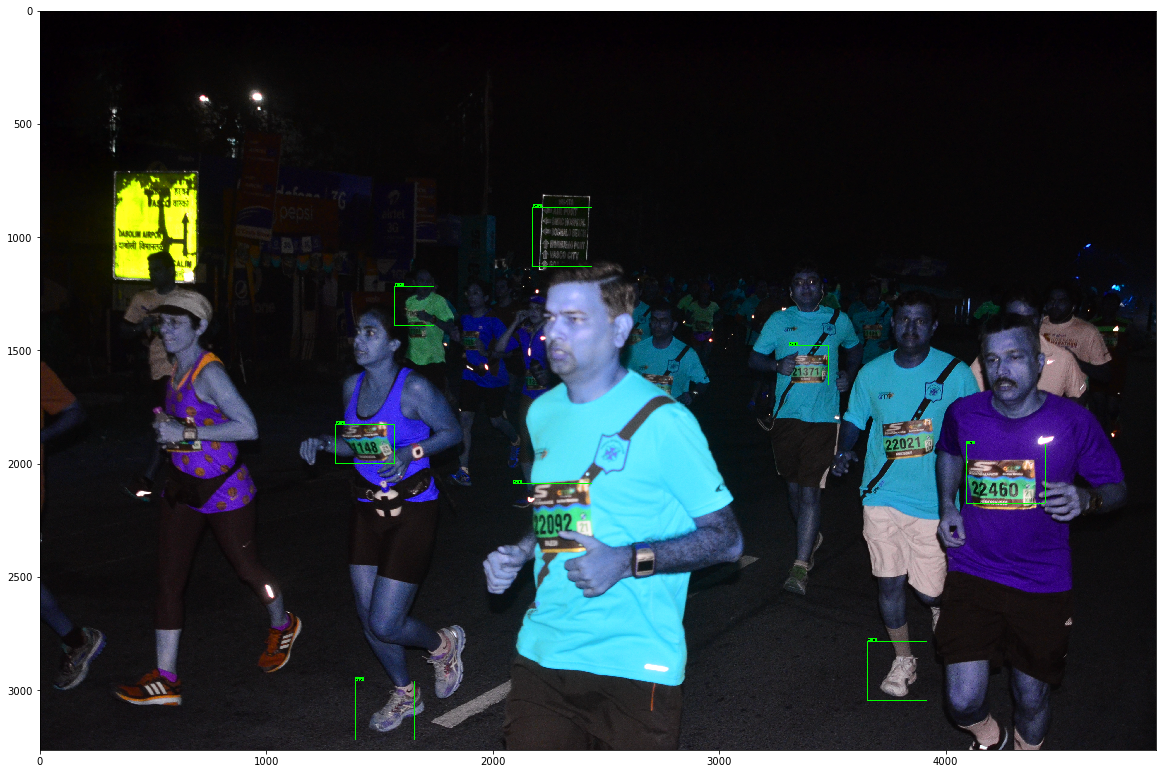

In [123]:
filename = "/Users/Alex/Desktop/yolo_crop/run4/2dc85b4090468f66b12eaaf8c1a76c8a.jpg"

bib_regions = extract_bib_regions_from_image(filename, 
                                             "/Users/Alex/Desktop/yolo_crop/run4/bib_only")

plt.imshow(annotate_image(cv2.imread(filename), bib_regions))